In [2]:
import os
import sys
import json
import glob
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
warnings.filterwarnings('ignore')
pplt.rc.update({'reso':'xx-hi','figure.dpi':100})

In [3]:
with open('/global/cfs/cdirs/m4334/sferrett/monsoon-kernels/scripts/configs.json','r',encoding='utf-8') as f:
    CONFIGS = json.load(f)
SPLITSDIR  = CONFIGS['filepaths']['splits']    
MODELSDIR  = CONFIGS['filepaths']['models']
PREDSDIR   = CONFIGS['filepaths']['predictions']
MODELS     = CONFIGS['models']
SPLIT      = 'valid'   
SEED       = 42

In [7]:
with xr.open_dataset(os.path.join(SPLITSDIR,f'{SPLIT}.h5'),engine='h5netcdf') as ds:
    truepr = ds.pr.load()
results = {}
for model in MODELS:
    name,description = model['name'],model['description']
    pattern   = f'{name}_seed*_{SPLIT}_predictions.nc'
    filepaths = glob.glob(os.path.join(PREDSDIR,pattern))
    if filepaths:
        seedresults = []
        for filepath in filepaths:
            with xr.open_dataset(filepath,engine='h5netcdf') as ds:
                predpr = ds.pr.load()
            ytrue,ypred = xr.align(truepr,predpr,join='inner')
            seedresults.append(dict(ytrue=ytrue,ypred=ypred))
        results[name] = dict(description=description,seeds=seedresults)
print(f'Found {len(results)} completed models for `{SPLIT}`')

Found 7 completed models for `valid`


In [8]:
def get_r2(ytrue,ypred,dims=None):
    dims  = list(ytrue.dims) if dims is None else dims
    ssres = ((ytrue-ypred)**2).sum(dim=dims,skipna=True)
    sstot = ((ytrue-ytrue.mean(dim=dims,skipna=True))**2).sum(dim=dims,skipna=True)
    return 1-ssres/sstot

In [9]:
barsdata = []
for runname,result in results.items():
    description = result['description']
    seeds       = result['seeds']
    r2values    = []
    for seedresult in seeds:
        ytrue,ypred = seedresult['ytrue'],seedresult['ypred']
        r2 = get_r2(ytrue,ypred,dims=None)
        r2values.append(float(r2))
    r2mean = np.mean(r2values)
    r2std = np.std(r2values) if len(r2values)>1 else 0.0
    color = ('yellow3' if ('kernel' in runname and 'nonparametric' in runname)
             else 'red4' if ('kernel' in runname and 'nonparametric' not in runname)
             else 'blue4')
    barsdata.append((runname,description,r2mean,r2std,color))
barsdata = sorted(barsdata,key=lambda x:x[2])

labels  = [item[1] for item in barsdata]
r2means = [item[2] for item in barsdata]
r2stds  = [item[3] for item in barsdata]
colors  = [item[4] for item in barsdata]

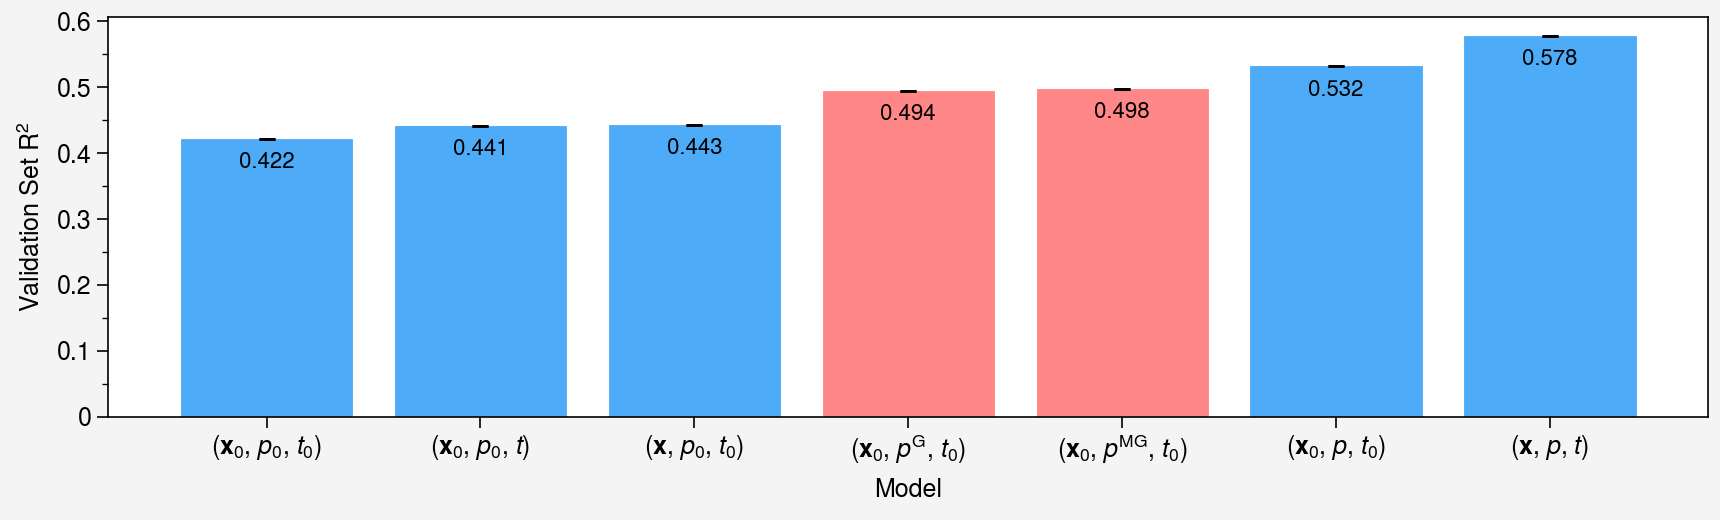

In [10]:
fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=8,refheight=2)
ax.format(xlabel='Model',ylabel='Validation Set R$^2$',yticks=0.1,yminorticks=0.05,grid=False)
bars = ax.bar(labels,r2means,yerr=r2stds,color=colors,capsize=3)
for bar,mean,std in zip(bars,r2means,r2stds):
    label_text = f'{r2_m:.3f}' if r2_s == 0 else f'{r2_m:.3f}±{r2_s:.3f}'
    ax.text(bar.get_x()+bar.get_width()/2,bar.get_height()-0.02,label_text,ha='center',va='top',fontsize=8)
pplt.show()

fig.save('../figs/bars.jpeg',dpi=300)